# Deconvolving Real Spectra

In this example, we demonstrate how to take into account real response matrices from the Chandra X-ray Telescope to deconvolve X-ray spectra. Instead of deconvolving complicated spectra, we will be creating simple powerlaw spectra with a gaussian added to model line emission. 

As a brief reminder, when looking at X-ray spectra, we do not see the true spectrum of the source but rather the convolution of the real spectrum with the instrumental response. For certain instrumnets, such as the ACIS instrument on Chandra, these response matrices can vary drastically; therefore, it is extremely useful to have a methodology to deconvolve the observed spectrum from the instrumental response to obtain the true source's spectrum. Unfortunately, this can not be done using traditional methods (see https://arxiv.org/abs/2105.09470). However, we can use our RIM to achieve this deconvolution for us!

In this example, we will be using tools developed by  the Chandra team. Therefore, we will be using the `ciao` python package. Instructions for downloading this can be found at https://cxc.cfa.harvard.edu/ciao/download/index.html.

Steps:
 - 1) Create response matrices
 - 2) Create mock spectra
 - 3) Set up and fit RIM
 - 4) Verify results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
import sys
from astropy.io import fits

from ciao_contrib.runtool import *


sys.path.append("/home/carterrhea/Documents/astroRIM/")  # Full path to AstroRIM module 
from RIM_sequence import RIM
from RIM_model import RIM_Model_1D  # Import name  of architecture to use
from RIM_physical import calc_grad_standard  # Import name of gradient log likelihood
plt.style.use('light.mplstyle')


2023-06-29 18:25:39.312987: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 18:25:39.434400: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-29 18:25:39.437552: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2023-06-29 18:25:39.437566: I tensorflow/compiler/xla/stream_executor/cuda

In [2]:
n = 32  # Size of spectrum
N = 5000  # Number of spectra

## Step 1: Response Matrices
We are going to build a function that will construct a set of response matrices on the fly to be used to create our spectra. To build the response matrices, we have to take a random observation's event and aphist files as a template. 

In [3]:
Obs_path = 'Data/'
evt_path = Obs_path+'acisf07923_repro_evt2.fits'
asol_path = Obs_path+'pcadf07923_000N001_asol1.fits'
# Step 1: Read in evt and asol file
evt_file = fits.open(evt_path)
evt_header = evt_file[0].header  # The information we need to change is in the first (ID 0) header
asol_file = fits.open(asol_path)
asol_header = asol_file[1].header  # The information we need to change is in the second (ID 1) header


In [4]:
# Now we will step through our sampling of different values to create our resposne matrices
n_samples = 5
ra_space = np.random.uniform(50, 60, n_samples)
dec_space = np.random.uniform(50, 60, n_samples)
roll_space = np.random.uniform(5, 10, n_samples)
sourcepixelx_space = np.random.uniform(3800, 4000, n_samples)
sourcepixely_space = np.random.uniform(3900, 4200, n_samples)
rmf_dict = {}  # {id: rmf_matrix}

In [5]:
for ct in np.arange(n_samples):  # Now we sample the spaces
    # Step 2: Update Asol File
    # We need to update the asol file parameters RA_PNT, DEC_PNT, ROLL_PNT
    ra_ = ra_space[ct]
    dec_ = dec_space[ct]
    roll_ = roll_space[ct]
    asol_header['RA_PNT'] = ra_
    asol_header['DEC_PNT'] = dec_
    asol_header['ROLL_PNT'] = roll_
    asol_file[1].header = asol_header  # Update header
    asol_file.writeto(asol_path, overwrite=True)
    # Step 3: Create asphist file
    # Now we can run asphist to create the asphist file
    asphist.punlearn()
    asphist.infile = asol_path
    asphist.outfile = 'tmp/asphist_temp.fits'
    asphist.evtfile = evt_path
    asphist.clobber = True
    asphist()
    # Step 4: Update the header for the newly created asphist file
    #asphist_file = fits.open('asphist_temp.fits')
    #asphist_header = asphist_file[0].header
    # Step 4: Run mkarf with new asphist file
    mkarf.punlearn()
    mkarf.sourcepixelx = sourcepixelx_space[ct]
    mkarf.sourcepixely = sourcepixely_space[ct]
    mkarf.asphistfile = "asphist_temp.fits"
    mkarf.outfile = 'tmp/%i_arf.fits'%ct
    mkarf.engrid = "0.1:10.0:0.01"
    mkarf.obsfile = evt_path
    mkarf.detsubsys = "ACIS-I3;CONTAM=YES"
    mkarf.clobber = True
    mkarf()
    # Step 5: Create RMF file
    # We first have to create a spectrum that will be used to create the weighted rmf
    dmextract.punlearn()
    dmextract.infile = evt_path+"[(x,y)=circle(%i,%i,32)][bin pi=1:1024:1]"%(sourcepixelx_space[ct],sourcepixely_space[ct])  # Circle centered at our predefined point with a radius of 32 pixels
    dmextract.outfile = 'tmp/temp_pi.fits'
    dmextract.wmap = "det=8"
    dmextract.clobber = True
    dmextract()
    # Now use mkacisrmf to create the rmf
    mkacisrmf.punlearn()
    mkacisrmf.infile = "CALDB"
    mkacisrmf.outfile = 'tmp/%i_rmf.rmf'%ct
    mkacisrmf.energy = '0.1:10.0:0.01'
    mkacisrmf.channel = '1:1024:1'
    mkacisrmf.chantype = "PI"
    mkacisrmf.wmap = 'tmp/temp_pi.fits'
    mkacisrmf.gain='CALDB'
    mkacisrmf.asolfile = asol_path
    mkacisrmf.clobber = True
    mkacisrmf()
    # Step 6: Combine rmf and arf to create 2d response matrix image
    rmfimg.punlearn()
    rmfimg.infile = 'tmp/%i_rmf.rmf'%ct
    rmfimg.outfile = 'tmp/%i_rmf.img'%ct
    rmfimg.arf = 'tmp/arf_temp.fits'
    rmfimg.arfout = 'tmp/%i_arf.img'%ct
    rmfimg.product = True
    rmfimg.clobber = True
    rmfimg()
    rmf_data = fits.open('tmp/%i_rmf.img'%ct)[0].data
    rmf_dict[ct] = rmf_data

## Step 2: Create Mock Spectra

In [6]:
def gaussian(x, mu, sig):
    return 1*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) + 1*np.abs(x+1e-8)**-1.1

def conv_mat(n):
    """
    Obtain convolution matrix
    """
    num_ = np.random.randint(0,n_samples)
    spectra_response =  rmf_dict[num_][100:132, 100:132]  # We randomly selected the region to have some interesting information and be the correct size
    return spectra_response

def create_convolved(N):
    '''
    Create convolved powerlaw + gaussian
    Args:
     n - number of Gausians
    Return:
     gaussians - List of convolved Gaussians
    '''
    a = 0.01  # Powerlaw slope
    gaussians_initial = []  # List of initial Gaussians
    powerlaw_conv = []  # List of Powerlaws used in convolution
    gaussians_final = []  # List of final Gaussians after convolution
    noise = []  # List of noises added
    x = np.linspace(0.1,5,n)
    for i in range(N):
        # Create original 1D Gaussian (32 points)
        gaus_orig = gaussian(x, np.random.uniform(0.9,1.1), np.random.uniform(0.1, 0.1))
        gaussians_initial.append(gaus_orig/np.max(gaus_orig))
        # Convolve with additional Gaussian
        conv_mat_ = conv_mat(n)
        gaus_conv = conv_mat_@gaus_orig
        # Add noise
        noise_ = np.random.normal(0,0.1, n)
        gaus_noise = gaus_conv + noise_
        gaussians_final.append(gaus_noise/np.max(gaus_noise))
        powerlaw_conv.append(conv_mat_)
        noise.append(noise_)

    return gaussians_initial,gaussians_final,powerlaw_conv,noise,x

# Create N instances
gaussians_initial, gaussians_final,powerlaw_conv,noise,x = create_convolved(N)

Let's check out the convolved spectra and the real spectra

Text(0.5, 0, 'X-axis')

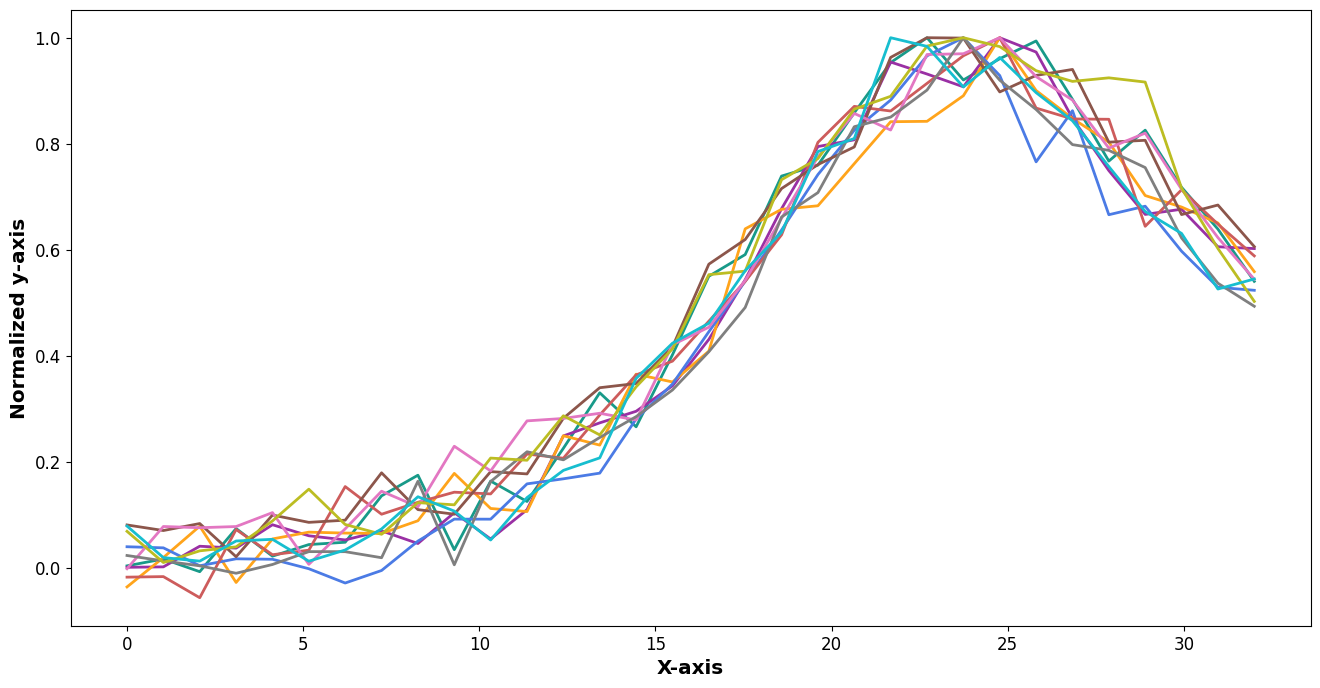

In [7]:
fig = plt.figure(figsize=(16,8))
for i in range(10):
    test_spec = gaussians_final[i]
    plt.plot(np.linspace(0,len(test_spec), len(test_spec)), test_spec)
plt.ylabel('Normalized y-axis')
plt.xlabel('X-axis')

Text(0.5, 0, 'X-axis')

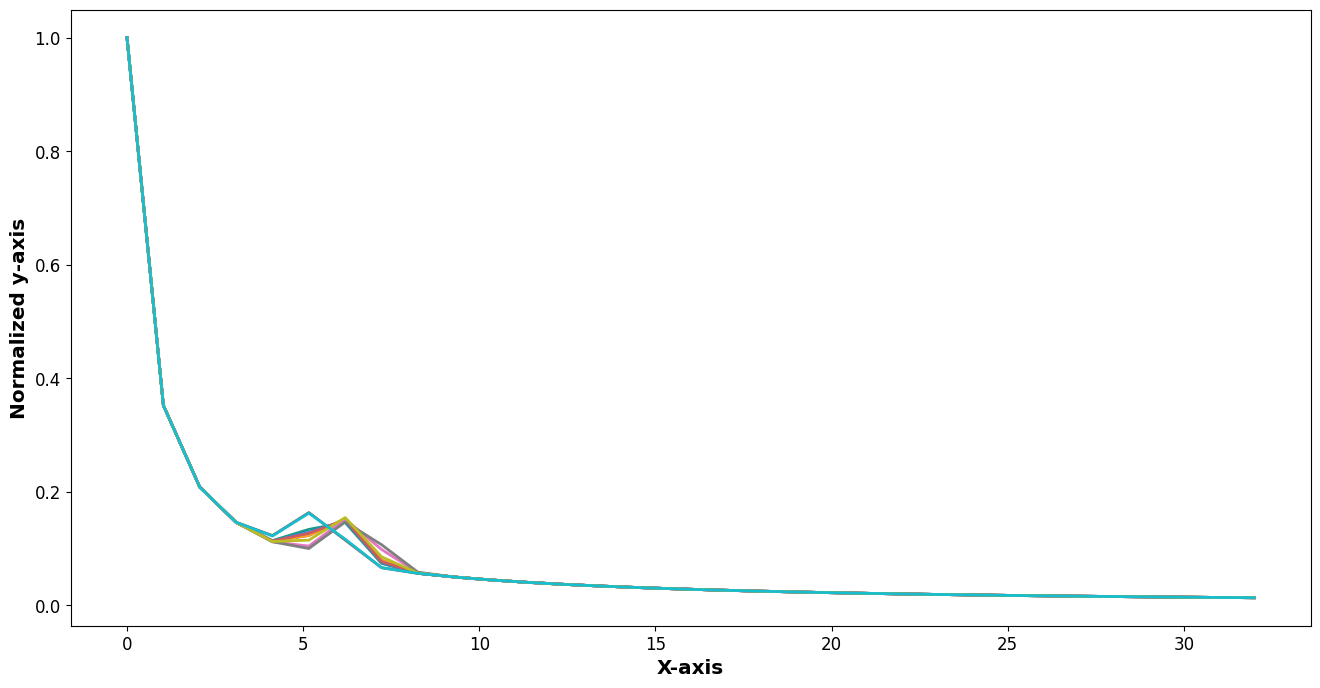

In [8]:
fig = plt.figure(figsize=(16,8))
for i in range(10):
    test_spec = gaussians_initial[i]
    plt.plot(np.linspace(0,len(test_spec), len(test_spec)), test_spec)
plt.ylabel('Normalized y-axis')
plt.xlabel('X-axis')

## Step 3: Set up and fit RIM

In [9]:
# Create training, validation, and test sets
train_percentage = 0.7
valid_percentage = 0.9
test_percentage = 1.0
len_X = len(gaussians_initial)
# Training
X_train = gaussians_initial[:int(train_percentage*len_X)]
Y_train = gaussians_final[:int(train_percentage*len_X)]
A_train = powerlaw_conv[:int(train_percentage*len_X)]
N_train = noise[:int(train_percentage*len_X)]
#Validation
X_valid = gaussians_initial[int(train_percentage*len_X):int(valid_percentage*len_X)]
Y_valid = gaussians_final[int(train_percentage*len_X):int(valid_percentage*len_X)]
A_valid = powerlaw_conv[int(train_percentage*len_X):int(valid_percentage*len_X)]
N_valid = noise[int(train_percentage*len_X):int(valid_percentage*len_X)]
#Test
X_test = gaussians_initial[int(valid_percentage*len_X):]
Y_test = gaussians_final[int(valid_percentage*len_X):]
A_test = powerlaw_conv[int(valid_percentage*len_X):]
N_test = noise[int(valid_percentage*len_X):]

In [10]:
# Initiate RIM architecture to use. We are using the standard RIM archtecture defined in `rim_model.py` as `RIM_Model_1D`.
rim_architecture = RIM_Model_1D(conv_filters=4, kernel_size=3, rnn_units=[256, 256])
# Load model and define hyper parameters
epochs = 20  # Number of  epochs
batch_size = 16  # Batch size
learning_rate = 1e-2  # Initial learning rate
time_steps = 5  # Time steps
dimensions = 1  # Dimensions of the problem
learning_rate_function  = 'step'  # Type of learning rate function (options are: step, exponential, or linear)
model = RIM(rim_model=rim_architecture, gradient=calc_grad_standard, input_size=n, dimensions=dimensions, t_steps=time_steps, 
            learning_rate=learning_rate, learning_rate_function=learning_rate_function, decay=0.8, epochs_drop=5)

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train, A_train, N_train))
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(2)
# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid, A_valid, N_valid))
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)
val_dataset = val_dataset.prefetch(2)

In [11]:
# Fit model
ysol_valid, training_loss, valid_loss, learning_rates = model.fit(batch_size, epochs, train_dataset, val_dataset)

Training epoch: 1::  Completion: 0.00%  ETA 00:51:53  loss: 8.056E-01  MSE: 7.678E-01
Training epoch: 1::  Completion: 4.59%  ETA 00:00:30  loss: 8.491E-02  MSE: 2.851E-01
Training epoch: 1::  Completion: 9.17%  ETA 00:00:29  loss: 3.569E-02  MSE: 1.742E-01
Training epoch: 1::  Completion: 13.76%  ETA 00:00:28  loss: 2.077E-02  MSE: 1.280E-01
Training epoch: 1::  Completion: 18.35%  ETA 00:00:26  loss: 1.626E-02  MSE: 1.012E-01
Training epoch: 1::  Completion: 22.94%  ETA 00:00:25  loss: 1.458E-02  MSE: 8.401E-02
Training epoch: 1::  Completion: 27.52%  ETA 00:00:24  loss: 9.755E-03  MSE: 7.202E-02
Training epoch: 1::  Completion: 32.11%  ETA 00:00:22  loss: 9.109E-03  MSE: 6.317E-02
Training epoch: 1::  Completion: 36.70%  ETA 00:00:21  loss: 6.718E-03  MSE: 5.639E-02
Training epoch: 1::  Completion: 41.28%  ETA 00:00:20  loss: 5.985E-03  MSE: 5.099E-02
Training epoch: 1::  Completion: 45.87%  ETA 00:00:19  loss: 5.476E-03  MSE: 4.656E-02
Training epoch: 1::  Completion: 50.46%  ETA 0

KeyboardInterrupt: 

## Step 4: Verify Results

In [ ]:
plt.plot(np.linspace(-1,1,n), [sol for sol in ysol_valid.numpy()[-1,:]], label='Predicted')
plt.plot(np.linspace(-1,1,n), X_valid[-1], label='True')
plt.legend()

In [ ]:
plt.plot(np.linspace(0, epochs, epochs), training_loss, label='training')
plt.plot(np.linspace(0, epochs, epochs), valid_loss, label='validation')
plt.legend()

In [ ]:
#test_dataset = (Y_test, A_test)#tf.data.Dataset.from_tensor_slices((Y_test, A_test))
test_dataset = tf.data.Dataset.from_tensor_slices((Y_test, A_test, N_test))
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)
ysol = model(test_dataset)

In [ ]:
#ysol = [val.numpy() for val in ysol[0]]
ysol_list = []
for val in ysol:
    ysol_ = [val.numpy() for val in val]
    ysol_list.append(ysol_)


In [ ]:
fig = plt.figure(figsize=(16,8))
plt.plot(np.linspace(-1,1,n), Y_test[-1], label='Noisy', color='C1')
plt.legend(prop={'size': 20})
plt.ylabel('Normalized y-axis', fontsize=20)
plt.xlabel('X-axis', fontsize=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('RIM Example using a Noisy Gaussian')
#plt.savefig('Gaussian_noisy.png')

In [ ]:


fig = plt.figure(figsize=(16,8))
plt.plot(np.linspace(-1,1,n), Y_test[-1], label='Noisy', color='C1')
plt.plot(np.linspace(-1,1,n), X_test[-1], label='True', color='C8', linewidth=4)
plt.legend(prop={'size': 20})
plt.ylabel('Normalized y-axis', fontsize=20)
plt.xlabel('X-axis', fontsize=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('RIM Example using a Noisy Gaussian')
#plt.savefig('Gaussian_noisy_true.png')

In [ ]:
fig = plt.figure(figsize=(16,8))
plt.plot(np.linspace(-1,1,n), Y_test[-1], label='Noisy')
plt.plot(np.linspace(-1,1,n), X_test[-1], label='True', linewidth=4)
plt.plot(np.linspace(-1,1,n), ysol_list[-1][-1][-1].reshape(n), label='Predicted', linestyle='dashed', linewidth=3)
plt.legend(prop={'size': 20})
plt.ylabel('Normalized y-axis', fontsize=20)
plt.xlabel('X-axis', fontsize=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('RIM Example using a Noisy Gaussian')
#plt.savefig('Gaussian_complete.png')

### 